In [1]:
from config import Config
from series_processing import process_series, bin_data
from file_io import (
    check_and_load_or_process)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

Text(0.5, 1.0, 'Transfer Funtion')

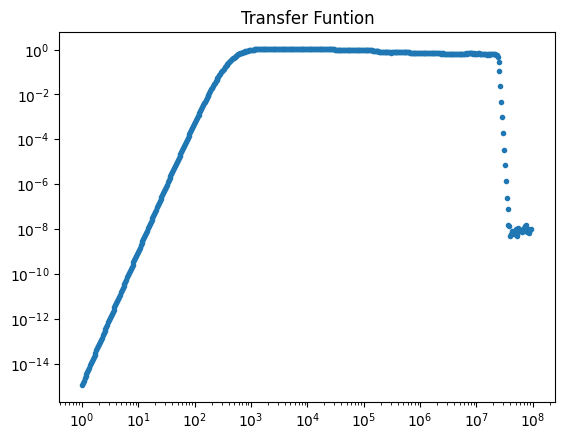

In [2]:
def transfer(freq, response):
    df = pd.read_csv(r"C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241121\filter_response.txt")
    freqs = np.array(df[df.keys()[0]])
    r = np.array(df[df.keys()[1]])
    interpolation = scipy.interpolate.interp1d(freqs, r, fill_value = "extrapolate")

    def low_freq_fit(x):
        A, B =   -306.24611144, 184968.79274103
        C = 1 / (2*np.pi*10**-6*1000)
        Sallen_key = x**2 / (x**2 + A*x + B)
        RC_high_pass = x / (x +C )
        return (Sallen_key*RC_high_pass)**2

    return np.where(freq < 10**5, response / low_freq_fit(freq), response / interpolation(freq))

# Check out the tranfer function

freq = np.logspace(0, 8, 500)  # Frequencies from 10 Hz to 1 MHz
flat_psd = np.ones_like(freq)  # Flat PSD
psd_combined_f = transfer(freq, flat_psd)

plt.plot(freq, 1/psd_combined_f, ".")
plt.xscale("log")
plt.yscale("log")
plt.title("Transfer Funtion")

Processing data for 
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 0
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 1
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 2
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 3
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 4
data_col  X
Reading  C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4 5
data_col  X
MASS TOTAL IS 1.1309733552923254e-14


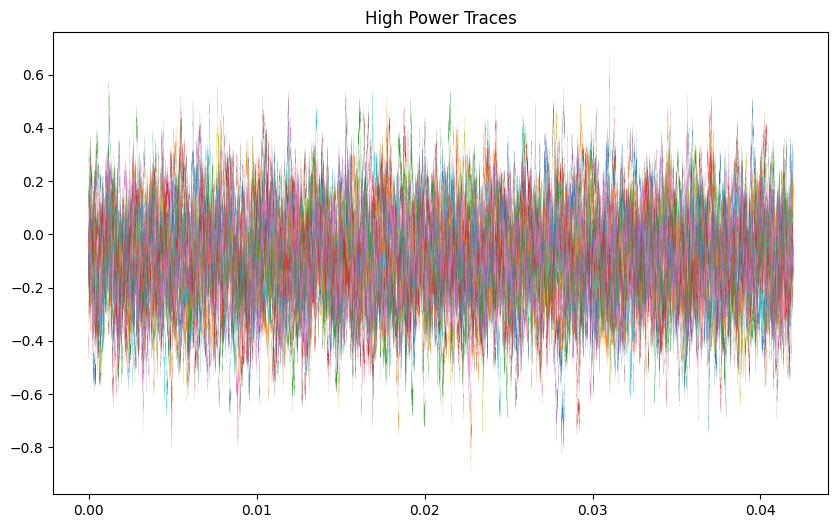

In [3]:
HP_filename = r"C:\Users\GaGe\Desktop\Brownian_Data_2024\October_Gage_Data\20241122\2_um_short_4"
hp_offset = 3
num_files = 6
traces_per_file = 3
traces_HP = check_and_load_or_process("", hp_offset, HP_filename, "X", num_files, traces_per_file)

time_hp = np.arange(0, len(traces_HP[0]['series']))
conf_hp = Config(**traces_HP[0]['args'])
time_hp = time_hp * (1/conf_hp.sampling_rate)

plt.figure(figsize=(10, 6))
for trace in traces_HP:
    plt.plot(time_hp, trace['series'], linewidth = .05)

plt.title("High Power Traces")
plt.show()


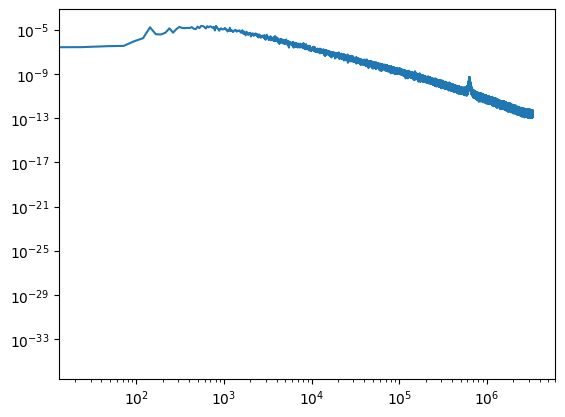

In [4]:
#bin data
bin = 30
all_hp_series = []

for trace in traces_HP:
    series = bin_data(trace['series'], bin)
    all_hp_series.append(series)

all_hp_psd = []
frequency = 0

for series in all_hp_series:
    frequency, psd = scipy.signal.periodogram(series, fs=conf_hp.sampling_rate/bin, scaling="density")
    all_hp_psd.append(psd)

hp_avg_psd = np.mean(all_hp_psd, axis=0)

plt.plot(frequency, hp_avg_psd)
plt.xscale('log')
plt.yscale('log')

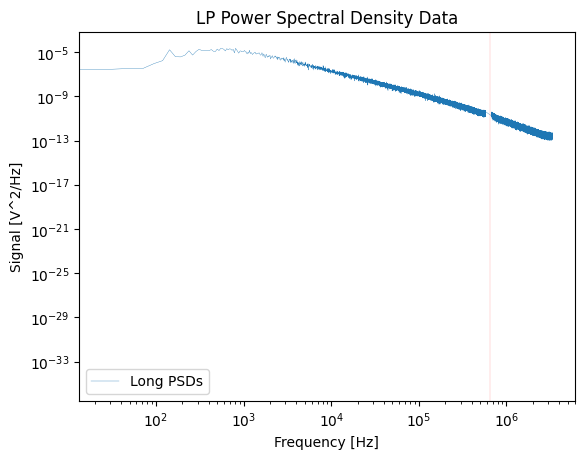

In [5]:
def remove_frequency_artifact(freq, psd, artifact_center, artifact_bandwidth):

    # Create a mask for frequencies to keep (inverse of frequencies to remove)
    keep_mask = ~(np.abs(freq - artifact_center) <= artifact_bandwidth / 2)

    # Use boolean indexing to keep only the desired frequencies and PSD values
    cleaned_freq = freq[keep_mask]
    cleaned_psd = psd[keep_mask]

    return cleaned_freq, cleaned_psd


artifact_center_width = [(6.3e5, 1e5)]

for center, width in artifact_center_width:
    frequency, hp_avg_psd = remove_frequency_artifact(frequency, hp_avg_psd, center, width)

plt.plot(frequency, hp_avg_psd, label="Long PSDs", linewidth=.25)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("LP Power Spectral Density Data")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")
plt.axvline(6.5e5, linewidth=.1, color='r')
plt.show()

C:\Users\GaGe\AppData\Local\Temp\ipykernel_14400\2214581731.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.where(freq < 10**5, response / low_freq_fit(freq), response / interpolation(freq))


Text(0, 0.5, 'Signal [V^2/Hz]')

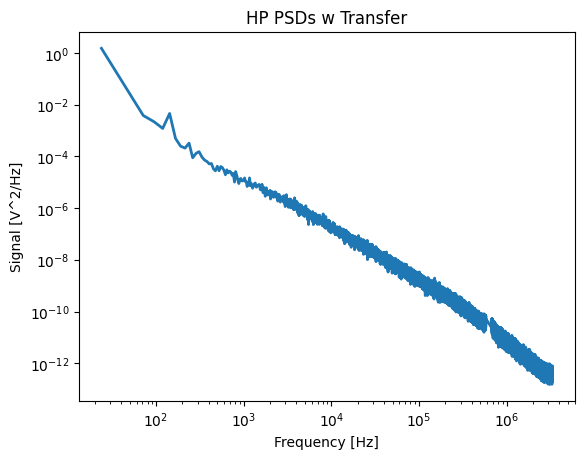

In [6]:
hp_avg_psd = transfer(frequency, hp_avg_psd)

plt.plot(frequency, hp_avg_psd,linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.title("HP PSDs w Transfer")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Signal [V^2/Hz]")

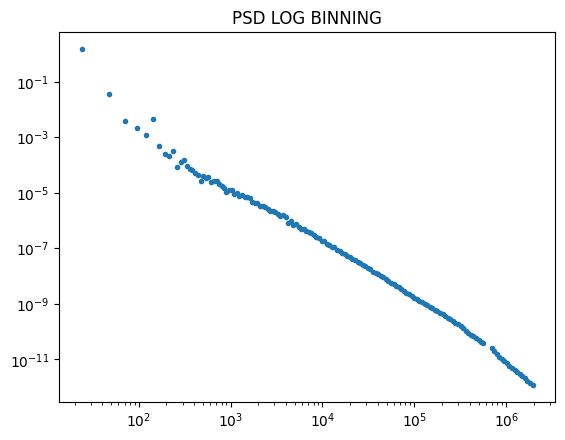

In [7]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

frequency, hp_avg_psd = log_bin_array(frequency, hp_avg_psd, 5, 2e6, 200)

plt.plot(frequency, hp_avg_psd, ".")
plt.title("PSD LOG BINNING")
plt.xscale("log")
plt.yscale("log")
plt.show()

Optimization terminated successfully.
         Current function value: -2262.171865
         Iterations: 3
         Function evaluations: 179
True Optimization terminated successfully.
Parameters =  [1.00091615e-16 0.00000000e+00 4.80628190e+07]


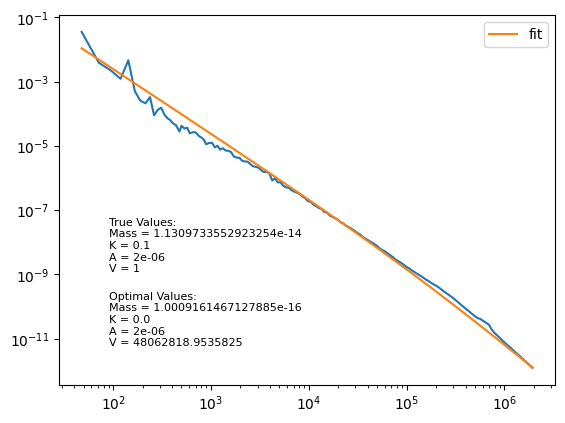

In [8]:
from fitting import log_bin_array, PSD_fitting, PSD_fitting_func

a_guess = 2e-6
v_guess = 1e9
m_guess = 1e-14
k_guess = 0

# bounds = [(a_guess, a_guess), (m_guess, m_guess), (k_guess, k_guess), (v_guess, v_guess)]

optimal_parameters = PSD_fitting(frequency[1:], hp_avg_psd[1:], a_guess, m_guess, k_guess, v_guess)
optimal_parameters.x[0] = optimal_parameters.x[0]*1e-14
PSD_fit = PSD_fitting_func(frequency[1:] * 2 * np.pi, optimal_parameters.x[0], optimal_parameters.x[1], a_guess, optimal_parameters.x[2])

print("Parameters = ", optimal_parameters.x)
plt.text(0.1, 0.1, f"Optimal Values:\nMass = {optimal_parameters.x[0]}\nK = {optimal_parameters.x[1]}\nA = {a_guess}\nV = {optimal_parameters.x[2]}",
         fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)
plt.text(0.1, 0.3, f"True Values:\nMass = {conf_hp.mass_total}\nK = {.1}\nA = {conf_hp.a}\nV = {1}",
         fontsize=8, ha='left', va='bottom', transform=plt.gca().transAxes)

plt.plot(frequency[1:], hp_avg_psd[1:])

# plt.axhline(2*const.k_b*conf.temp*config.gamma/k_guess**2)

plt.plot(frequency[1:], PSD_fit, label="fit")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()
